In [25]:
import pandas as pd 
import numpy as np 
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
pd.set_option('display.max_columns', None)

In [40]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [41]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [42]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [43]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонок с типом данных object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df


In [44]:
df = prepare_obj_data(df, obj_cols)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [45]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [46]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y_stratified, random_state=42)


In [47]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

## Classification

In [48]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [49]:
def plot_importance_reg(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.coef_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [61]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [51]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

In [122]:
def train_model_reg(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

Learning rate set to 0.104069
0:	learn: 0.4945940	total: 43.5ms	remaining: 43.4s
1:	learn: 0.3672890	total: 67.7ms	remaining: 33.8s
2:	learn: 0.2777376	total: 93.4ms	remaining: 31s
3:	learn: 0.2168453	total: 123ms	remaining: 30.6s
4:	learn: 0.1727505	total: 156ms	remaining: 31s
5:	learn: 0.1433905	total: 213ms	remaining: 35.3s
6:	learn: 0.1246077	total: 244ms	remaining: 34.6s
7:	learn: 0.1104373	total: 290ms	remaining: 35.9s
8:	learn: 0.1017053	total: 328ms	remaining: 36.2s
9:	learn: 0.0955205	total: 361ms	remaining: 35.8s
10:	learn: 0.0892147	total: 395ms	remaining: 35.5s
11:	learn: 0.0848101	total: 427ms	remaining: 35.2s
12:	learn: 0.0824167	total: 461ms	remaining: 35s
13:	learn: 0.0796924	total: 494ms	remaining: 34.8s
14:	learn: 0.0778121	total: 538ms	remaining: 35.3s
15:	learn: 0.0760769	total: 576ms	remaining: 35.4s
16:	learn: 0.0749366	total: 614ms	remaining: 35.5s
17:	learn: 0.0739001	total: 650ms	remaining: 35.5s
18:	learn: 0.0733195	total: 681ms	remaining: 35.1s
19:	learn: 0.0

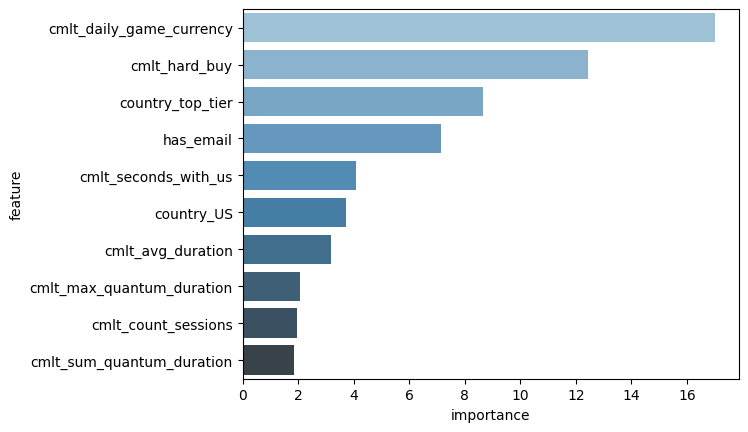

In [125]:
params = {
    'iterations': 200,
    'depth': 3,
    'loss_function': 'RMSE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20 
}

model, features = train_model(CatBoostClassifier(),
                              X_train, 
                              y_train_binary,
                              5,
                              scoring='roc_auc',
                              cross_val=True)

In [126]:
X_train_regression = X_train[y_train_binary == 1]
y_train_regression = y_train[y_train_binary == 1]

0:	learn: 44570.0456114	total: 3.78ms	remaining: 15.1s
50:	learn: 40295.9983465	total: 79ms	remaining: 6.12s
100:	learn: 39494.9903722	total: 145ms	remaining: 5.6s
150:	learn: 39191.6812745	total: 206ms	remaining: 5.24s
200:	learn: 38868.8554648	total: 274ms	remaining: 5.18s
250:	learn: 38564.2552363	total: 332ms	remaining: 4.96s
300:	learn: 38424.8345058	total: 391ms	remaining: 4.8s
350:	learn: 38271.2480336	total: 449ms	remaining: 4.67s
400:	learn: 38133.5519228	total: 510ms	remaining: 4.58s
450:	learn: 38011.8856099	total: 569ms	remaining: 4.48s
500:	learn: 37854.6281464	total: 626ms	remaining: 4.37s
550:	learn: 37716.8057349	total: 721ms	remaining: 4.51s
600:	learn: 37615.0232213	total: 784ms	remaining: 4.44s
650:	learn: 37543.0356306	total: 842ms	remaining: 4.33s
700:	learn: 37453.1051889	total: 900ms	remaining: 4.24s
750:	learn: 37342.8946089	total: 960ms	remaining: 4.15s
800:	learn: 37227.4030101	total: 1.02s	remaining: 4.07s
850:	learn: 37127.4172780	total: 1.08s	remaining: 3.9

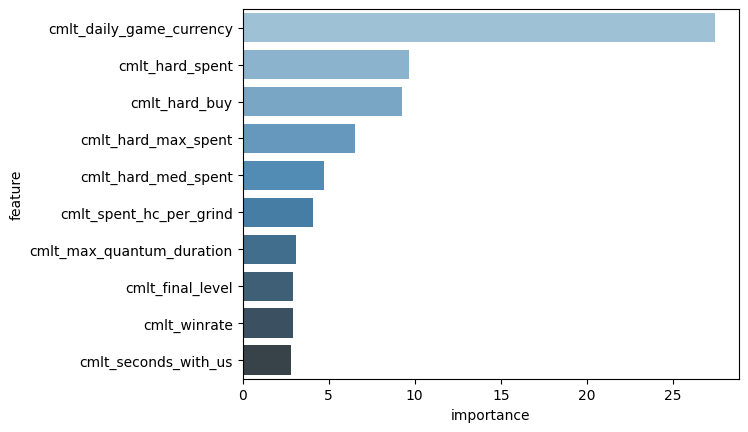

In [159]:
params = {
    'iterations': 4000,
    'depth': 3,
    'loss_function': 'RMSE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20 
}

model_reg, features_reg = train_model_reg(CatBoostRegressor(**params),
                              X_train_regression, 
                              y_train_regression,
                              5,
                              scoring='neg_mean_squared_error',
                              cross_val=True)

In [160]:
y_pred_train_binary = model.predict(X_train)
y_pred_test_binary = model.predict(X_test)

In [161]:
y_pred_train_regression = model_reg.predict(X_train_regression)
y_pred_test_regression = model_reg.predict(X_test[y_test_binary == 1])

In [162]:
smape_train_classification = SMAPE(y_train_binary, y_pred_train_binary)
smape_test_classification = SMAPE(y_test_binary, y_pred_test_binary)


In [163]:
smape_train_regression = SMAPE(y_train_regression, y_pred_train_regression)
smape_test_regression = SMAPE(y_test[y_test_binary == 1], y_pred_test_regression) 

mse_train = mean_squared_error(y_train_regression, y_pred_train_regression)
mse_test = mean_squared_error(y_test[y_test_binary == 1], y_pred_test_regression)

rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)


In [164]:
print(f"SMAPE for train data (classification): {smape_train_classification}")
print(f"SMAPE for test data (classification): {smape_test_classification}")


print(f"SMAPE for train data (regression): {smape_train_regression}")
print(f"SMAPE for test data (regression): {smape_test_regression}")

print(f"MSE for train data: {mse_train}")
print(f"MSE for test data: {mse_test}")

print(f"RMSE for train data: {rmse_train}")
print(f"RMSE for test data: {rmse_test}")


SMAPE for train data (classification): 0.03068376258305371
SMAPE for test data (classification): 0.03479860805567777
SMAPE for train data (regression): 1.3512691169636126
SMAPE for test data (regression): 1.3958827657803736
MSE for train data: 992900771.6180142
MSE for test data: 1241589505.8935184
RMSE for train data: 31510.32801508125
RMSE for test data: 35236.19596229875
